In [1]:
from codecs import BOM32_BE
from ctypes import alignment
from unittest import result
from xml.dom.expatbuilder import parseString
import numpy as np
import pandas as pd
import pydicom as dicom
import os
import matplotlib.pyplot as plt
import cv2
import math

import tensorflow._api.v2.compat.v1 as tf 
tf.disable_v2_behavior()
import pandas as pd
import tflearn
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Flatten, Dense, Dropout
import numpy as np
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential


from tkinter import *
from tkinter import messagebox,ttk
import tkinter as tk
from PIL import Image,ImageTk

Instructions for updating:
non-resource variables are not supported in the long term
curses is not supported on this machine (please install/reinstall curses for an optimal experience)


In [ ]:
class LCD_CNN:
    def __init__(self,root):
        self.root=root
        #window size
        self.root.geometry("1006x500+0+0")
        self.root.resizable(False, False)
        self.root.title("Lung Cancer Detection")

        img4=Image.open(r"LCD.jpg")
        img4=img4.resize((1006,500),Image.ANTIALIAS)
        #Antialiasing is a technique used in digital imaging to reduce the visual defects that occur when high-resolution images are presented in a lower resolution.
        self.photoimg4=ImageTk.PhotoImage(img4)

        bg_img=Label(self.root,image=self.photoimg4)
        bg_img.place(x=0,y=50,width=1006,height=500)

        # title Label
        title_lbl=Label(text="Lung Cancer Detection",font=("Bradley Hand ITC",30,"bold"),bg="black",fg="white",)
        title_lbl.place(x=0,y=0,width=1006,height=50)

        #button 1
        self.b1=Button(text="Import Data",cursor="hand2",command=self.import_data,font=("Times New Roman",15,"bold"),bg="white",fg="black")
        self.b1.place(x=80,y=130,width=180,height=30)

        #button 2
        self.b2=Button(text="Pre-Process Data",cursor="hand2",command=self.preprocess_data,font=("Times New Roman",15,"bold"),bg="white",fg="black")
        self.b2.place(x=80,y=180,width=180,height=30)
        self.b2["state"] = "disabled"
        self.b2.config(cursor="arrow")

        #button 3
        self.b3=Button(text="Train Data",cursor="hand2",command=self.train_data,font=("Times New Roman",15,"bold"),bg="white",fg="black")
        self.b3.place(x=80,y=230,width=180,height=30)
        self.b3["state"] = "disabled"
        self.b3.config(cursor="arrow")

#Data Import lets you upload data from external sources and combine it with data you collect via Analytics.
    def import_data(self):
        ##Data directory
        self.dataDirectory = 'sample_images/'
        self.lungPatients = os.listdir(self.dataDirectory)

        ##Read labels csv 
        self.labels = pd.read_csv('stage1_labels.csv', index_col=0)

        ##Setting x*y size to 10
        self.size = 10

        ## Setting z-dimension (number of slices to 5)
        self.NoSlices = 5

        messagebox.showinfo("Import Data" , "Data Imported Successfully!") 

        self.b1["state"] = "disabled"
        self.b1.config(cursor="arrow") 
        self.b2["state"] = "normal"
        self.b2.config(cursor="hand2")   

# Data preprocessing is the process of transforming raw data into an understandable format.
    def preprocess_data(self):

        def chunks(l, n):
            count = 0
            for i in range(0, len(l), n):
                if (count < self.NoSlices):
                    yield l[i:i + n]
                    count = count + 1


        def mean(l):
            return sum(l) / len(l)
        #Average


        def dataProcessing(patient, labels_df, size=10, noslices=5, visualize=False):
            label = labels_df._get_value(patient, 'cancer')
            path = self.dataDirectory + patient
            slices = [dicom.read_file(path + '/' + s) for s in os.listdir(path)]
            slices.sort(key=lambda x: int(x.ImagePositionPatient[2]))

            new_slices = []
            slices = [cv2.resize(np.array(each_slice.pixel_array), (size, size)) for each_slice in slices]

            chunk_sizes = math.floor(len(slices) / noslices)
            for slice_chunk in chunks(slices, chunk_sizes):
                slice_chunk = list(map(mean, zip(*slice_chunk)))
                new_slices.append(slice_chunk)

            if label == 1: #Cancer Patient
                label = np.array([0, 1])
            elif label == 0:    #Non Cancerous Patient
                label = np.array([1, 0])
            return np.array(new_slices), label


        imageData = []
        #Check if Data Labels is available in CSV or not
        for num, patient in enumerate(self.lungPatients):
            if num % 51 == 0:
                print('Saved -', num)
            try:
                img_data, label = dataProcessing(patient, self.labels, size=self.size, noslices=self.NoSlices)
                imageData.append([img_data, label,patient])
            except KeyError as e:
                print('Data is unlabeled')


        ##Results= Image Data and lable.
        np.save('imageDataNew-{}-{}-{}.npy'.format(self.size, self.size, self.NoSlices), imageData)

        messagebox.showinfo("Pre-Process Data" , "Data Pre-Processing Done Successfully!") 

        self.b2["state"] = "disabled"
        self.b2.config(cursor="arrow") 
        self.b3["state"] = "normal"
        self.b3.config(cursor="hand2")

# Data training is the process of training the model based on the dataset and then predict on new data.
    def train_data(self):    

        imageData = np.load('imageDataNew-10-10-5.npy',allow_pickle=True)
        trainingData = imageData[0:50]
        validationData = imageData[50:51]

        training_data=Label(text="Total Training Data: " + str(len(trainingData)),font=("Times New Roman",13,"bold"),bg="black", fg="white",)
        training_data.place(x=750,y=150,width=200,height=18)   

        validation_data=Label(text="Total Validation Data: " + str(len(validationData)),font=("Times New Roman",13,"bold"),bg="black",fg="white",)
        validation_data.place(x=750,y=190,width=200,height=18)  

        x = tf.placeholder('float')
        y = tf.placeholder('float')
        size = 10
        keep_rate = 0.8
        NoSlices = 5
        def convolution3d(x, W):
            return tf.nn.conv3d(x, W, strides=[1, 1, 1, 1, 1], padding='SAME')


        def maxpooling3d(x):
            return tf.nn.max_pool3d(x, ksize=[1, 2, 2, 2, 1], strides=[1, 2, 2, 2, 1], padding='SAME')

        def cnn(x):
            x = tf.reshape(x, shape=[-1, size, size, NoSlices, 1])
            convolution1 = tf.nn.relu(
                convolution3d(x, tf.Variable(tf.random_normal([3, 3, 3, 1, 32]))) + tf.Variable(tf.random_normal([32])))
            convolution1 = maxpooling3d(convolution1)
            convolution2 = tf.nn.relu(
                convolution3d(convolution1, tf.Variable(tf.random_normal([3, 3, 3, 32, 64]))) + tf.Variable(
                    tf.random_normal([64])))
            convolution2 = maxpooling3d(convolution2)
            convolution3 = tf.nn.relu(
-                convolution3d(convolution2, tf.Variable(tf.random_normal([3, 3, 3, 64, 128]))) + tf.Variable(
                    tf.random_normal([128])))
            convolution3 = maxpooling3d(convolution3)
            convolution4 = tf.nn.relu(
                convolution3d(convolution3, tf.Variable(tf.random_normal([3, 3, 3, 128, 256]))) + tf.Variable(
                    tf.random_normal([256])))
            convolution4 = maxpooling3d(convolution4)
            convolution5 = tf.nn.relu(
                convolution3d(convolution4, tf.Variable(tf.random_normal([3, 3, 3, 256, 512]))) + tf.Variable(
                    tf.random_normal([512])))
            convolution5 = maxpooling3d(convolution4)
            fullyconnected = tf.reshape(convolution5, [-1, 256])
            fullyconnected = tf.nn.relu(
                tf.matmul(fullyconnected, tf.Variable(tf.random_normal([256, 256]))) + tf.Variable(tf.random_normal([256])))
            fullyconnected = tf.nn.dropout(fullyconnected, keep_rate)
            output = tf.matmul(fullyconnected, tf.Variable(tf.random_normal([256, 2]))) + tf.Variable(tf.random_normal([2]))
            return output

        def network(x):
            prediction = cnn(x)
            cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=prediction, labels=y))
            optimizer = tf.train.AdamOptimizer(learning_rate=1e-3).minimize(cost)
            epochs = 60
            with tf.Session() as session:
                session.run(tf.global_variables_initializer())
                for epoch in range(epochs):
                    epoch_loss = 0
                    for data in trainingData:
                        try:
                            X = data[0]
                            Y = data[1]
                            _, c = session.run([optimizer, cost], feed_dict={x: X, y: Y})
                            epoch_loss += c
                        except Exception as e:
                            pass
                        
                    correct = tf.equal(tf.argmax(prediction, 1), tf.argmax(y, 1))
                    accuracy = tf.reduce_mean(tf.cast(correct, 'float'))
                    print('Epoch', epoch + 1, 'completed out of', epochs, 'loss:', epoch_loss)
                    print('Accuracy:', accuracy.eval({x: [i[0] for i in validationData], y: [i[1] for i in validationData]}))
                x1 = accuracy.eval({x: [i[0] for i in validationData], y: [i[1] for i in validationData]})

                final_accuracy=Label(text="Final Accuracy: " + str(x1),font=("Times New Roman",13,"bold"),bg="black", fg="white",)
                final_accuracy.place(x=750,y=230,width=200,height=18)  

                patients = []
                actual = []
                predicted = []

                finalprediction = tf.argmax(prediction, 1)
                actualprediction = tf.argmax(y, 1)
                for i in range(len(validationData)):
                    patients.append(validationData[i][2])
                for i in finalprediction.eval({x: [i[0] for i in validationData], y: [i[1] for i in validationData]}):
                    if(i==1):
                        predicted.append("Cancer")
                    else:
                        predicted.append("No Cancer")
                for i in actualprediction.eval({x: [i[0] for i in validationData], y: [i[1] for i in validationData]}):
                    if(i==1):
                        actual.append("Cancer")
                    else:
                        actual.append("No Cancer")
                for i in range(len(patients)):
                    print("----------------------------------------------------")
                    print("Patient: ",patients[i])
                    print("Actual: ", actual[i])
                    print("Predicted: ", predicted[i])
                    print("----------------------------------------------------")

                y_actual = pd.Series(
                    (actualprediction.eval({x: [i[0] for i in validationData], y: [i[1] for i in validationData]})),
                    name='Actual')
                y_predicted = pd.Series(
                    (finalprediction.eval({x: [i[0] for i in validationData], y: [i[1] for i in validationData]})),
                    name='Predicted')

                df_confusion = pd.crosstab(y_actual, y_predicted).reindex(columns=[0,1],index=[0,1], fill_value=0)
                print('Confusion Matrix:\n')
                print(df_confusion)

                prediction_label=Label(text=">>>>    P R E D I C T I O N    <<<<",font=("Times New Roman",14,"bold"),bg="#778899", fg="black",)
                prediction_label.place(x=0,y=458,width=1006,height=20)   

                result1 = []

                for i in range(len(validationData)):
                    result1.append(patients[i])
                    if(y_actual[i] == 1):
                        result1.append("Cancer")
                    else:
                        result1.append("No Cancer")

                    if(y_predicted[i] == 1):
                        result1.append("Cancer")
                    else:
                        result1.append("No Cancer")
                        
                total_rows = int(len(patients))
                total_columns = int(len(result1)/len(patients))  

                heading = ["Patient: ", "Actual: ", "Predicted: "]

                self.root.geometry("1006x"+str(500+(len(patients)*20)-20)+"+0+0") 
                self.root.resizable(False, False)

                for i in range(total_rows):
                    for j in range(total_columns):
                 
                        self.e = Entry(root, width=42, fg='black', font=('Times New Roman',12,'bold')) 
                        self.e.grid(row=i, column=j) 
                        self.e.place(x=(j*335),y=(478+i*20))
                        self.e.insert(END, heading[j] + result1[j + i*3]) 
                        self.e["state"] = "disabled"
                        self.e.config(cursor="arrow")                     

                self.b3["state"] = "disabled"
                self.b3.config(cursor="arrow") 

                messagebox.showinfo("Train Data" , "Model Trained Successfully!")

                ## Function to plot confusion matrix
                def plot_confusion_matrix(df_confusion, title='Confusion matrix', cmap=plt.cm.gray_r):\

                    plt.matshow(df_confusion, cmap=cmap)  # imshow  
                    plt.title(title)
                    plt.colorbar()
                    tick_marks = np.arange(len(df_confusion.columns))
                    plt.title(title)
                    plt.xticks(tick_marks, df_confusion.columns, rotation=45)
                    plt.yticks(tick_marks, df_confusion.index)
                    plt.tight_layout()
                    plt.ylabel(df_confusion.index.name)
                    plt.xlabel(df_confusion.columns.name)
                    plt.show()
                plot_confusion_matrix(df_confusion)
               
        network(x)

# For GUI
if __name__ == "__main__":
        root=Tk()
        obj=LCD_CNN(root)
        root.mainloop()
      

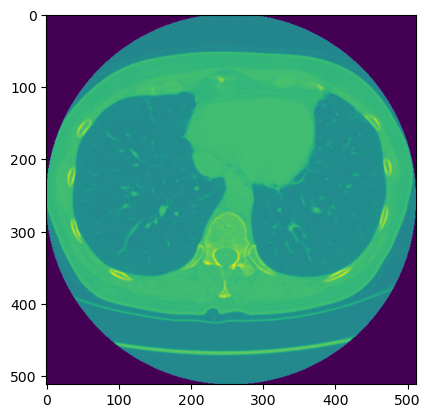

In [3]:
a = dicom.dcmread('sample_images/00cba091fa4ad62cc3200a657aeb957e/0a291d1b12b86213d813e3796f14b329.dcm')
plt.imshow(a.pixel_array)